In [2]:
include("../Source/types.jl")
include("../Source/functions.jl")

testSystem (generic function with 2 methods)

## Adjusting Proposal Maxima
The proposal maxima can be adjusted so that the accept probability is increased.

In [3]:
# Estimates the accept probability over M trials and updates simulation controls until
# a set of values is found such that the probability ∈ [0.3, 0.7]
function adjustSimConstants!(sim::Controls, ψ::State, M::Int64 = 40)
    CUTOFF_MAX = 42
    LOWER = 0.3
    UPPER = 0.7
    n = 0
    is_ok = false
    
    # First we get an estimate of the accept probability
    (av, std, series) = mcProposalFraction(ψ, sim, M)
    
    if av >= LOWER && av <= UPPER
        is_ok = true
    end
    
    while (!is_ok)
        if av < LOWER
            # Decrease simulation constants to increase chance of acceptance.
            sim.θmax /= 2
            sim.umax /= 2
            sim.Amax /= 2
        elseif av > UPPER
            # Increase simulation constants to decrease chance of acceptance.
            sim.θmax = sim.θmax + (π - sim.θmax)/2
            sim.umax = sim.umax + (0.5 - sim.umax)/2
            sim.Amax *= 2
        else
            is_ok = true
        end
        (av, std, series) = mcProposalFraction(ψ, sim, M)
        
        # Making sure the loop exits after CUTOFF_MAX times.
        n += 1
        if n >= CUTOFF_MAX
            println("WARNING: Could not find simulation constant such that update probability 
                was in [$(LOWER), $(UPPER)]")
            break
        end
    end
    return (av, std, series)
end

adjustSimConstants! (generic function with 2 methods)

In [69]:
A = Array{Controls}(4)

4-element Array{Controls,1}:
 #undef
 #undef
 #undef
 #undef

In [72]:
A

4-element Array{Controls,1}:
    Controls(1.0472, 0.4, 3.0)
 #undef                       
 #undef                       
 #undef                       

In [67]:
push!(A, Controls(1.0, 0.3, 1.0))

LoadError: [91mMethodError: no method matching push!(::Type{Array{Controls,N} where N}, ::Controls)[0m
Closest candidates are:
  push!(::Any, ::Any, [91m::Any[39m) at abstractarray.jl:1940
  push!(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at abstractarray.jl:1941
  push!([91m::Array{Any,1}[39m, ::ANY) at array.jl:653
  ...[39m

In [24]:
function adjustSimConstants(sim::Controls, ψ::State, M::Int64 = 40)
#    println("Adjusting simulation constants $(sim.θmax), $(sim.umax), $(sim.Amax)")
    CUTOFF_MAX = 42       # How many times the while loop should run. 
    LOWER = 0.3           # Minimum acceptance rate (AR)
    NEEDED_PROPOSALS = 5  # Number of sim with AR >= LOWER
    DIVI = 1.5            # The number the current value is divided by to get lower limit of search interval.
    TRIED_VALUES = 4      # Number of values to try in new interval
    
    proposedConstants = [copy(sim) for i=1:NEEDED_PROPOSALS]
    proposedAR = zeros(NEEDED_PROPOSALS)
    proposals = 0
    n = 0
    
    # First we get an estimate of the accept probability
    (av, std, series) = mcProposalFraction(ψ, sim, M)
    if av >= LOWER
        return av
    end
    
    s₀ = copy(sim)
    while (proposals < NEEDED_PROPOSALS)
        # The starting state of this loop will be that we have no proposals for sims that has acceptance rate higher
        # than LOWER (including the initial s₀)
        
        # First we look at Amax
        interval_end = s₀.Amax/DIVI
        tries_A = [Controls(s₀.θmax, s₀.umax, 
                s₀.Amax-x*(s₀.Amax-interval_end)/TRIED_VALUES) for x = 1:TRIED_VALUES]
        f_A = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_A[i], std, series) = mcProposalFraction(ψ, tries_A[i], M)
            # If we find a value with probability >= LOWER, then this is the largest such value we have found
            # and should be included in proposed constants
            if f_A[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_A[i]
                proposedAR[proposals] = f_A[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break

        # Then we try to vary umax
        interval_end = s₀.umax/DIVI
        tries_u = [Controls(s₀.θmax, s₀.umax - x*(s₀.umax-interval_end)/TRIED_VALUES,
                s₀.Amax) for x = 1:TRIED_VALUES]
        f_u = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_u[i], std, series) = mcProposalFraction(ψ, tries_u[i], M)
            if f_u[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_u[i]
                proposedAR[proposals] = f_u[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break

        # Then we try to vary θmax
        interval_end = s₀.θmax/DIVI
        tries_θ = [Controls(s₀.θmax - x*(s₀.θmax - interval_end)/TRIED_VALUES, s₀.umax,
                s₀.Amax) for x = 1:TRIED_VALUES]
        f_θ = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_θ[i], std, series) = mcProposalFraction(ψ, tries_θ[i], M)
            if f_θ[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_θ[i]
                proposedAR[proposals] = f_θ[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break
        
        # At this point in the loop we have tried to get some proposals but failed to get enough of them.
        # We need to start the loop again with a new starting state that is such that the accept ratio is
        # as high is possible so that we can get more proposals.
        accept_ratios = vcat(f_A, f_u, f_θ)
        tries = vcat(tries_A, tries_u, tries_θ)
        i_max = indmax(accept_ratios)   # Finding index of sim that gave highest accept ratio.
        s₀ = tries[i_max]               # Setting this sim to the initial one.
        
        
        n += 1
        if n >= CUTOFF_MAX
            println("WARNING: Could not find simulation constant such that update probability 
                was in [$(LOWER), $(UPPER)]")
            sim = s₀
            return accept_ratios[i_max]
        end
    end
    # The end situation of the loop is that we have a certain non-zero number of proposals.
    
    # Finding the distance from zero of the different proposals.
    norms = zeros(proposals)
    for i = 1:proposals
        norms[i] = proposedConstants[i].θmax^2 + proposedConstants[i].umax^2 + proposedConstants[i].Amax^2
    end
    i_max = indmax(norms)
    # Finally we return the simulation constants to the sim that has 
    # highest norm, and an accept ratio above LOWER.
    return proposedConstants[i_max], proposedAR[i_max]
end

adjustSimConstants (generic function with 2 methods)

In [22]:
import Base.copy

function copy(sim::Controls)
    return Controls(sim.θmax, sim.umax, sim.Amax)
end

function setValues!(sim_target::Controls, sim_source::Controls)
    sim_target.θmax = sim_source.θmax
    sim_target.umax = sim_source.umax
    sim_target.Amax = sim_source.Amax
    return
end

# Todo: make a version that does not waste the mc-Sweeps done for calibration of simulation constants somehow.
# -----------------------------------------------------------------------------------------------------------
# Given values for the physical constants of the system as well as the system size, we find the number of MC-sweeps it
# takes until the internal energy of the system reaches a more or less constant value.
function findEquilibrium(c::SystConstants, sim₁::Controls=Controls(π/3, 0.4, 3.0), 
        T::Int64=1000, ex::Float64=1.5, di::Int64=8)
    CUTOFF_MAX::Int64 = 16000
    ADJUST_INTERVAL::Int64 = 4000
    STD_NUMBER::Int64 = 1
    println("Finding Equilibrium of\n$(c)\n$(sim₁)")
    
    ψ₂ = State(2, c)
    sim₂ = copy(sim₁)
    ψ₁ = State(1, c)
    dE = zeros(T)
    
    # Check that the un-correllated state has higher energy than the correlated
    if E(ψ₂) <= E(ψ₁)
        error("Correlated state has higher energy than un-correlated")
    end
    
    tₛ = 0    # The wanted t₀ does not exist at or before this position.
    t₀ = T
    
    for i = 1:T
        dE[i] = E(ψ₂)-E(ψ₁)
        mcSweep!(ψ₁, sim₁)
        mcSweep!(ψ₂, sim₂)
    end
    
    # Adjust simulation constants as needed
    sim₁, ar = adjustSimConstants(sim₁, ψ₁)
    sim₂, ar = adjustSimConstants(sim₂, ψ₂)
    
    while tₛ < CUTOFF_MAX
        # Find the first occurence of dE <= 0 if it exists
        t₀ = T
        for i = (tₛ+1):T
            if dE[i] <= 0
                t₀ = i
                break
            end
        end
        
        while T <= t₀ && T < CUTOFF_MAX
            # If we couldn't find a t₀ in dE we have to try and increase simulation time
            tₛ = T
            T = Int(ceil(T*ex))
            for i = (tₛ+1):T
                print("$(round(i/CUTOFF_MAX*100,1))% of max\r") # Debug
                mcSweep!(ψ₁, sim₁)
                mcSweep!(ψ₂, sim₂)
                push!(dE, E(ψ₂) - E(ψ₁))
                
                # After ADJUST_INTERVAL # MCS we see if adjusting the simulations constants is neccessary.
                if i % ADJUST_INTERVAL == 0
                    sim₁, ar = adjustSimConstants(sim₁, ψ₁)
                    sim₂, ar = adjustSimConstants(sim₂, ψ₂)
                end
            end
            
            # Then we again see if we can find the first occurrence of dE <= 0 after tₛ
            t₀ = T
            for i = tₛ:T
                if dE[i] <= 0
                    t₀ = i
                    break
                end
            end
            
            # When the loop ends we should have the situation that T > t₀ where t₀ is the first occurrence
            # in dE where dE[t₀] <= 0
        end
        
        # Now we make sure that T is large enough such that [1,T] includes an interval [t₀, t₀+t₀/div]
        # so that an average can be performed
        t_end = t₀ + Int(ceil(t₀/di))
        while T <= t_end
            mcSweep!(ψ₁, sim₁)
            mcSweep!(ψ₂, sim₂)
            push!(dE, E(ψ₂) - E(ψ₁))
            T += 1
            
            # Adjust simulations constants if neccessary.
            if T % ADJUST_INTERVAL == 0
                sim₁, ar = adjustSimConstants(sim₁, ψ₁)
                sim₂, ar = adjustSimConstants(sim₂, ψ₂)
            end
        end
        
        # Now we calculate the average and standard deviation of dE over [t₀, T] and check if the
        # average is within a standard deviation of 0 at which point t₀ and dE is returned
        int = dE[t₀:T]
        av = mean(int)
        st = std(int)
        if abs(av) <= STD_NUMBER*st
            println("Equilibrium found at time $(t₀)
over the interval [$(t₀), $(T)]
s.t. <ΔE> = $(round(av,2)) ± $(round(st/sqrt(size(int,1)), 1))")
            return (t₀, dE, ψ₁, ψ₂, sim₁, sim₂)
        end
        
        # If we didn't find an interval that had an average close to 0 we assume this interval is ahead of us
        # and start again with an increased T, setting the starting point tₛ to the end of the interval.
        tₛ = T
        T = Int(ceil(T*ex))
        
        # Simulating new MCS
        for i = (tₛ+1):T
            mcSweep!(ψ₁, sim₁)
            mcSweep!(ψ₂, sim₂)
            push!(dE, E(ψ₂) - E(ψ₁))
            
            # Adjust simulations constants if neccessary.
            if i % ADJUST_INTERVAL == 0
                sim₁, ar = adjustSimConstants(sim₁, ψ₁)
                sim₂, ar = adjustSimConstants(sim₂, ψ₂)
            end
        end
    end
    return (-1, dE, ψ₁, ψ₂, sim₁, sim₂)
end


findEquilibrium (generic function with 5 methods)

## Debugging and Testing
The new version of findEquilibrium and adjustSimConstants!

In [6]:
using Plots
gr()

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 22     # System length
T = 0.12   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 100    # Number of measurements
Δt = 400  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

Controls(1.0471975511965976, 0.4, 3.0)

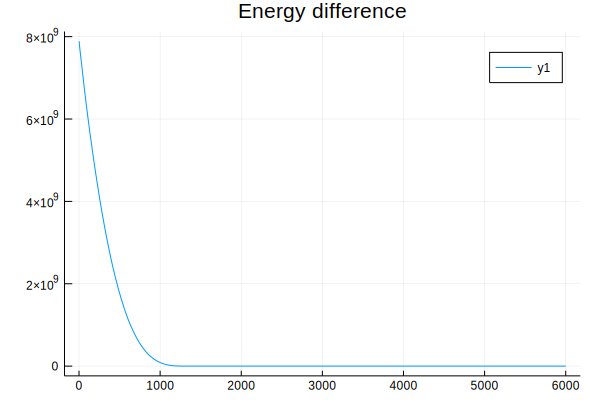

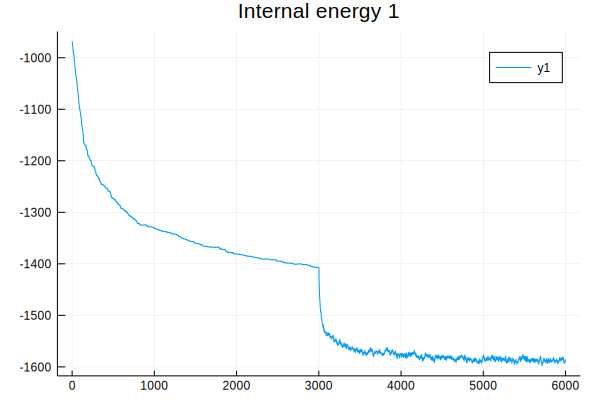

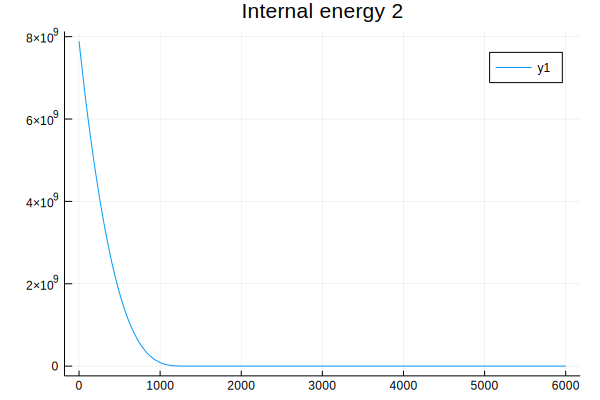

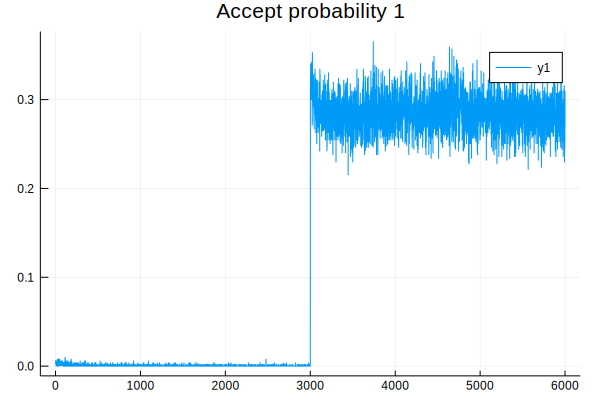

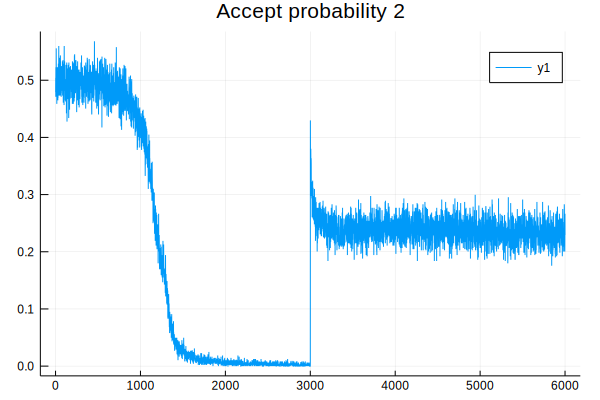

sim₁: (0.310280755910103, 0.17777777777777778, 0.06584362139917695)
sim₂: (0.310280755910103, 0.17777777777777778, 0.09754610577655845)


In [25]:
# Iterating over two intervals, one with initial simulation values, and one with adjusted values.

ψ₁ = State(1, syst)
sim₁ = copy(sim)
ψ₂ = State(2, syst)
sim₂ = copy(sim)
T = 3000
dE = zeros(2T)
E₁ = zeros(2T)
E₂ = zeros(2T)
p₁ = zeros(2T)
p₂ = zeros(2T)
for i = 1:T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end
sim₁, ar = adjustSimConstants(sim₁, ψ₁)
sim₂, ar = adjustSimConstants(sim₂, ψ₂)
for i = T+1:2T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end

# Plotting results
plt = plot(1:2T, dE, title="Energy difference")
display(plt)
plt = plot(1:2T, E₁, title="Internal energy 1")
display(plt)
plt = plot(1:2T, E₂, title="Internal energy 2")
display(plt)
plt = plot(1:2T, p₁, title="Accept probability 1")
display(plt)
plt = plot(1:2T, p₂, title="Accept probability 2")
display(plt)
println("sim₁: ($(sim₁.θmax), $(sim₁.umax), $(sim₁.Amax))")
println("sim₂: ($(sim₂.θmax), $(sim₂.umax), $(sim₂.Amax))")

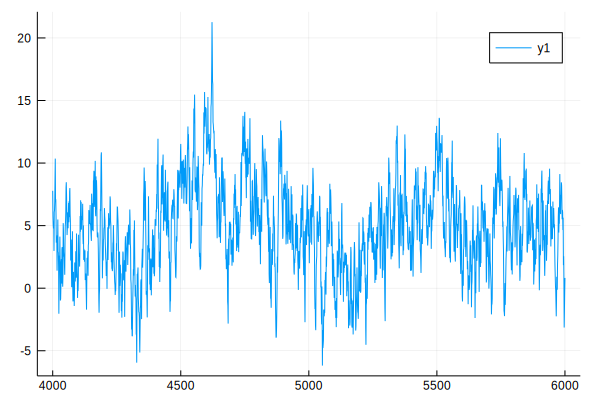

In [128]:
int = 4000:6000
plot(int, dE[int])

Plot probability as function of AmaX

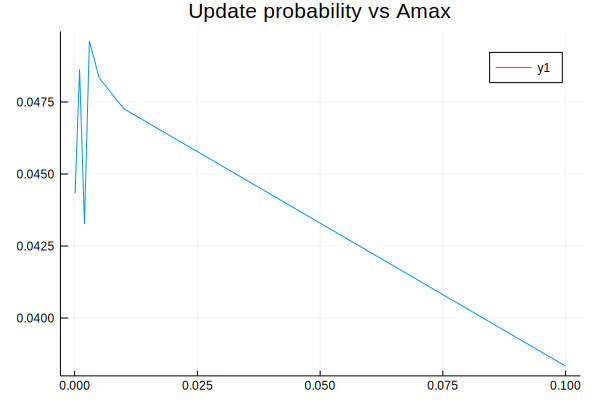

In [54]:
ψ = State(1, syst)
sim = Controls(π - π/3, 0.4, 3.0)
As = [0.1, 0.01, 0.005, 0.003, 0.002, 0.001, 0.0001]
N = size(As,1)
f_av = zeros(N)
M = 80

for i in 1:N
    sim.Amax = As[i]
    
    (f_av[i], std, err) = mcProposalFraction(ψ, sim, M)
end
plt = plot(As, f_av, title="Update probability vs Amax")
display(plt)

### Trying the find Equilibrium

In [244]:
(t₀, dE, ψ₁, ψ₂) = findEquilibrium(syst, sim, 2000);

Finding Equilibrium of
SystConstants(22, 1.0, 11.11111111111111, 0.3, -0.13636363636363635, 8.333333333333334)
Controls(1.0471975511965976, 0.4, 3.0)
Equilibrium found at time 10142
 over the interval [10142, 15188]

                s.t. <ΔE> = 2.95 ± 0.1


(10142, [7.54617e9, 7.52818e9, 7.51072e9, 7.49397e9, 7.47563e9, 7.45669e9, 7.43974e9, 7.4222e9, 7.40362e9, 7.38505e9  …  3.13425, 0.493743, 2.70236, 1.3603, 2.61934, 4.18478, 4.34221, 4.75938, 1.90185, 2.64427], State(LatticeSite[LatticeSite([-0.26045, -1.08317], 2.25626, 0.661654, 0.289644, 0.957134) LatticeSite([-0.297761, -2.00361], 2.73021, 0.480483, 0.166187, 0.986094) … LatticeSite([-1.84181, -1.41429], 2.08662, 3.05214, 0.524325, 0.851518) LatticeSite([0.824543, 0.324004], 1.00443, 5.79902, 0.934829, 0.355098); LatticeSite([-0.120996, 0.911705], 1.69706, 6.20644, 0.283552, 0.958957) LatticeSite([0.797166, 0.787448], 5.6535, 5.97363, 0.242874, 0.970058) … LatticeSite([-1.1641, 0.13658], 3.92894, 0.941351, 0.143808, 0.989606) LatticeSite([-0.760654, -0.595888], 0.987, 5.65478, 0.930103, 0.367299); … ; LatticeSite([-0.592551, 1.16266], 0.211251, 6.11064, 0.0625422, 0.998042) LatticeSite([-0.213224, -0.20326], 5.94465, 4.87467, 0.971974, 0.23509) … LatticeSite([3.01276, 2.24934], 5.

In [1]:
int = 15500:size(dE, 1)
@show mean(dE[int])
@show std(dE[int])
plot(int, dE[int])

LoadError: [91mUndefVarError: dE not defined[39m

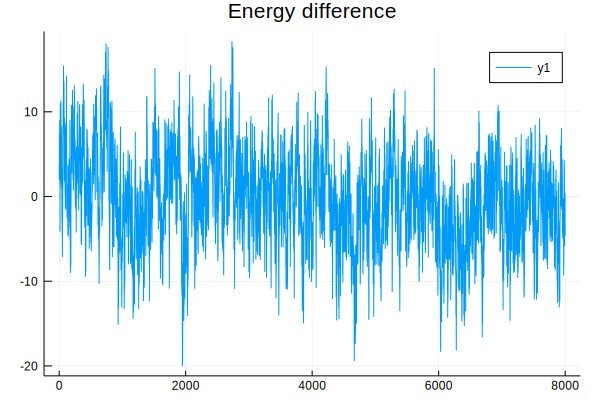

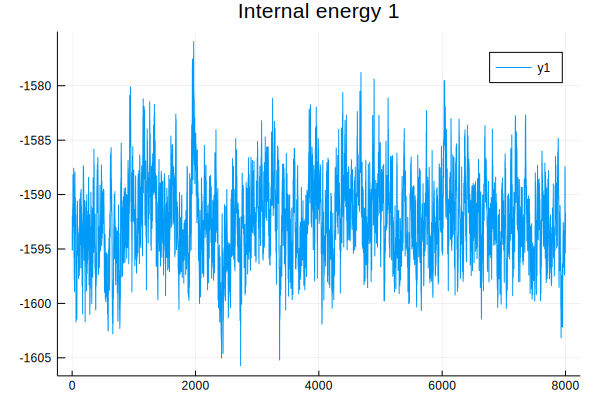

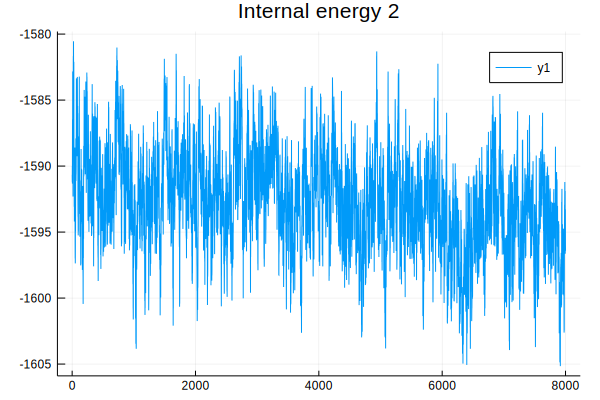

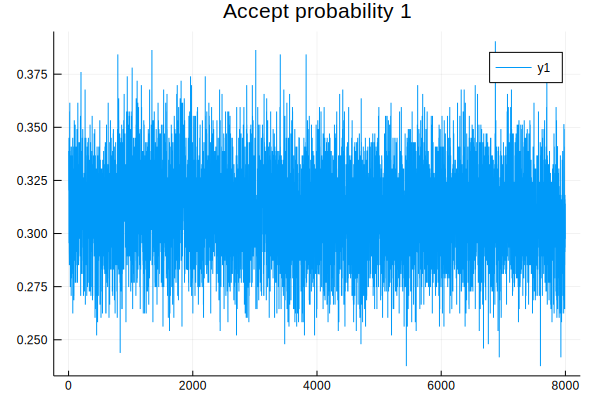

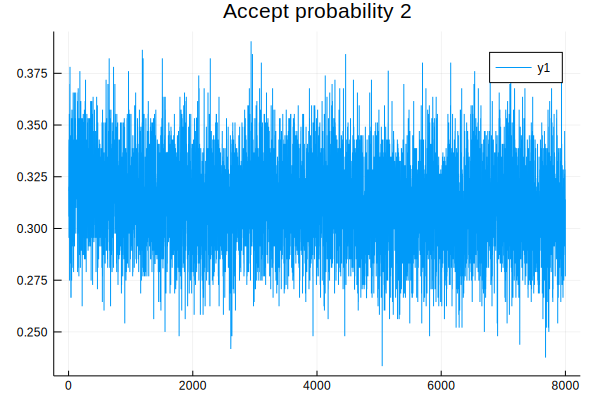

In [256]:
sim₁ = copy(sim)
sim₂ = copy(sim)
T = 4000
dE = zeros(2T)
E₁ = zeros(2T)
E₂ = zeros(2T)
p₁ = zeros(2T)
p₂ = zeros(2T)
for i = 1:T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end
adjustSimConstants!(sim₁, ψ₁)
adjustSimConstants!(sim₂, ψ₂)
for i = T+1:2T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end

# Plotting results
plt = plot(1:2T, dE, title="Energy difference")
display(plt)
plt = plot(1:2T, E₁, title="Internal energy 1")
display(plt)
plt = plot(1:2T, E₂, title="Internal energy 2")
display(plt)
plt = plot(1:2T, p₁, title="Accept probability 1")
display(plt)
plt = plot(1:2T, p₂, title="Accept probability 2")
display(plt)

In [257]:
@show mean(dE)
@show std(dE)
@show std(dE)/sqrt(size(dE,1))

mean(dE) = -0.32166828509262335
std(dE) = 5.410005822503407
std(dE) / sqrt(size(dE, 1)) = 0.06048570388893639


0.06048570388893639

**Conclusion:** There seemed to be a finite size effect when L<16 that resulted in energies stuck at slightly different values.

# TODO: Version that takes in two states and tries to find equilibrium for a fixed number of MCS and a set sim.

# TODO: Version of mcSweep that returns the energy-difference for faster calculation of energies in equilibrium routines.

In [7]:
# Same as mcSweep but adds up the energy-differences and returns it.
function mcSweepEn!(ψ::State, sim::Controls = Controls(π/3, 0.4, 3.0))
    
    δE = 0.0
   
    # Find size of the lattice L
    const L::Int64 = ψ.consts.L
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    δE += metropolisHastingUpdate!(ψ, [1,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        δE += metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    δE += metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        δE += metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    δE += metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        δE += metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    δE += metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        δE += metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        δE += metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    end
    return δE
end


mcSweepEn! (generic function with 2 methods)

### Testing that it gives correct energy

In [13]:
println("Checking that mcSweepEn! gives the same energy difference as taking E_new - E_old")
ψ = State(2, syst)
ψ_old = copy(ψ)
δE = 0.0
T = 1000 # Number of MCS
for i = 1:T
    δE += mcSweepEn!(ψ)
end
println(δE)
println(E(ψ)- E(ψ_old))
println(@test isapprox(δE, E(ψ)- E(ψ_old), atol=0, rtol=1e-13))

-7.955481983479408e9
-7.955481983479424e9
Test Passed


In [19]:
# Same as mcSweep but adds up the energy-differences and fraction of accepted updates and return it.
function mcSweepEnFrac!(ψ::State, sim::Controls = Controls(π/3, 0.4, 3.0))
    
    δE = 0.0
    upEn = 0.0
    count = 0
   
    # Find size of the lattice L
    const L::Int64 = ψ.consts.L
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    upEn = metropolisHastingUpdate!(ψ, [1,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    if upEn != 0.0
        count += 1
    end
    δE += upEn
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        upEn = metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
        if upEn != 0.0
            count += 1
        end
        δE += upEn
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    upEn = metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    if upEn != 0.0
        count += 1
    end
    δE += upEn
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        upEn = metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
        if upEn != 0.0
            count += 1
        end
        δE += upEn
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    upEn = metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    if upEn != 0.0
        count += 1
    end
    δE += upEn
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        upEn = metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
        if upEn != 0.0
            count += 1
        end
        δE += upEn
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    upEn = metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
    if upEn != 0.0
        count += 1
    end
    δE += upEn
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        upEn = metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
        if upEn != 0.0
            count += 1
        end
        δE += upEn
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        upEn = metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, sim)
        if upEn != 0.0
            count += 1
        end
        δE += upEn
    end
    return (δE, count/L^2)
end

mcSweepEnFrac! (generic function with 2 methods)

### Testing mcSweepEnFrac
it should give the same energy difference as $E(\phi\to\phi')$

In [21]:
println("Checking that mcSweepEnFrac")
ψ = State(2, syst)
ψ_old = copy(ψ)
δE = 0.0
T = 1000 # Number of MCS
for i = 1:T
    (δe, ar) = mcSweepEnFrac!(ψ)
    δE += δe
end
println(δE)
println(E(ψ)- E(ψ_old))
println(@test isapprox(δE, E(ψ)- E(ψ_old), atol=0, rtol=1e-13))

-7.694774604805392e9
-7.694774604805388e9
Test Passed


In [127]:
# Same as mcProposalFraction but does update the state.
# The number of times the state has been updated can be surmised from the input parameter M.
# Does not return the series of acceptance-rates unlike mcProposalFraction
function mcProposalFraction!(ψ::State, sim::Controls=Controls(π/2, 0.4, 3.0), M::Int64=500)
    L = ψ.consts.L
    fracs = zeros(M)
    
    # Go through the entire lattice M times and gain the statistic of whether it gets updated or not
    for i = 1:M
        fracs[i] = mcSweepFrac!(ψ, sim)
    end
    av = mean(fracs)
    stdev = std(fracs)
    return (av, stdev)
end

mcProposalFraction! (generic function with 3 methods)

# Making adjustSimConstants that changes the state and counts these MCS

In [161]:
# Same as adjustSimConstants but now changes the state while adjusting so that no amount of MCS gets wasted.
function adjustSimConstants!(sim::Controls, ψ::State, M::Int64 = 40)
    #println("Adjusting simulation constants $(sim.θmax), $(sim.umax), $(sim.Amax)")
    CUTOFF_MAX = 42       # How many times the while loop should run. 
    LOWER = 0.3           # Minimum acceptance rate (AR)
    NEEDED_PROPOSALS = 5  # Number of sim with AR >= LOWER
    DIVI = 1.5            # The number the current value is divided by to get lower limit of search interval.
    TRIED_VALUES = 4      # Number of values to try in new interval
    
    proposedConstants = [copy(sim) for i=1:NEEDED_PROPOSALS]
    proposedAR = zeros(NEEDED_PROPOSALS)
    proposals = 0
    n = 0
    adjustment_mcs = 0
    
    # First we get an estimate of the accept probability
    (av, std) = mcProposalFraction!(ψ, sim, M)
    adjustment_mcs = M
    if av >= LOWER
        return (av, adjustment_mcs)
    end
    
    s₀ = copy(sim)
    while (proposals < NEEDED_PROPOSALS)
        # The starting state of this loop will be that we have no proposals for sims that has acceptance rate higher
        # than LOWER (including the initial s₀)
        
        # First we look at Amax
        interval_end = s₀.Amax/DIVI
        tries_A = [Controls(s₀.θmax, s₀.umax, 
                s₀.Amax-x*(s₀.Amax-interval_end)/TRIED_VALUES) for x = 1:TRIED_VALUES]
        f_A = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_A[i], std) = mcProposalFraction!(ψ, tries_A[i], M)
            adjustment_mcs += M
            # If we find a value with probability >= LOWER, then this is the largest such value we have found
            # and should be included in proposed constants
            if f_A[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_A[i]
                proposedAR[proposals] = f_A[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break

        # Then we try to vary umax
        interval_end = s₀.umax/DIVI
        tries_u = [Controls(s₀.θmax, s₀.umax - x*(s₀.umax-interval_end)/TRIED_VALUES,
                s₀.Amax) for x = 1:TRIED_VALUES]
        f_u = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_u[i], std) = mcProposalFraction!(ψ, tries_u[i], M)
            adjustment_mcs += M
            if f_u[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_u[i]
                proposedAR[proposals] = f_u[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break

        # Then we try to vary θmax
        interval_end = s₀.θmax/DIVI
        tries_θ = [Controls(s₀.θmax - x*(s₀.θmax - interval_end)/TRIED_VALUES, s₀.umax,
                s₀.Amax) for x = 1:TRIED_VALUES]
        f_θ = zeros(TRIED_VALUES)
        for i = 1:TRIED_VALUES
            (f_θ[i], std) = mcProposalFraction!(ψ, tries_θ[i], M)
            adjustment_mcs += M
            if f_θ[i] >= LOWER
                proposals += 1
                proposedConstants[proposals] = tries_θ[i]
                proposedAR[proposals] = f_θ[i]
                break
            end
        end
        
        # If we have the needed number of proposals we exit the loop.
        (proposals >= NEEDED_PROPOSALS) && break
        
        # At this point in the loop we have tried to get some proposals but failed to get enough of them.
        # We need to start the loop again with a new starting state that is such that the accept ratio is
        # as high is possible so that we can get more proposals.
        accept_ratios = vcat(f_A, f_u, f_θ)
        tries = vcat(tries_A, tries_u, tries_θ)
        i_max = indmax(accept_ratios)   # Finding index of sim that gave highest accept ratio.
        s₀ = tries[i_max]               # Setting this sim to the initial one.
        
        
        n += 1
        if n >= CUTOFF_MAX
            println("WARNING: Could not find simulation constant such that update probability 
                was higher than $(LOWER)")
            sim = s₀
            return (accept_ratios[i_max], adjustment_mcs)
        end
    end
    # The end situation of the loop is that we have a number of proposals >= NEEDED_PROPOSALS.
    
    # Finding the distance from zero of the different proposals.
    norms = zeros(proposals)
    for i = 1:proposals
        norms[i] = proposedConstants[i].θmax^2 + proposedConstants[i].umax^2 + proposedConstants[i].Amax^2
    end
    i_max = indmax(norms)
    setValues!(sim, proposedConstants[i_max]) # Finally we update the simulation constants to the sim that has 
    # highest norm, and an accept ratio above LOWER.
    return (proposedAR[i_max], adjustment_mcs)
    # Return the acceptance ratio of the new sim and the number of Monte-Carlo Sweeps done during this adjustment.
end

adjustSimConstants! (generic function with 2 methods)

In [162]:
ψ = State(1, syst)
sim = Controls(π/3, 0.4, 3.0)
(ar, mcs1) = adjustSimConstants!(sim, ψ)

(0.30638020833333335, 7640)

# New Efficient findEquilibrium

In [163]:
# Version of find Equilibrium that doesn't waste MCS when adjusting sim Constants and also calculates energy based
# on return value of mcSweepEn! as well as gets rid of the use of dynamic arrays.
# -----------------------------------------------------------------------------------------------------------
# Given values for the physical constants of the system as well as the system size, we find the number of 
# MC-sweeps it takes until the internal energy of the system reaches a more or less constant value.
function findEquilibrium(c::SystConstants, sim₁::Controls=Controls(π/3, 0.4, 3.0), 
        T::Int64=1000, ex::Float64=1.5, di::Int64=8)
    CUTOFF_MAX::Int64 = 40000
    ADJUST_INTERVAL::Int64 = 2000
    STD_NUMBER::Int64 = 1
    println("Finding Equilibrium of\n$(c)\n$(sim₁)")
    
    ψ₂ = State(2, c)
    sim₂ = copy(sim₁)
    ψ₁ = State(1, c)
    dE = zeros(CUTOFF_MAX)
    E₁ = zeros(CUTOFF_MAX)
    E₂ = zeros(CUTOFF_MAX)
    adjustment_mcs = 0
    
    # Check that the un-correllated state has higher energy than the correlated
    if E(ψ₂) <= E(ψ₁)
        error("Correlated state has higher energy than un-correlated")
    end
    
    tₛ = 0    # The wanted t₀ does not exist at or before this position.
    t₀ = T
    
    E₁[1] = E(ψ₁)
    E₂[1] = E(ψ₂)
    dE[1] = E₂[1] - E₁[1]
    for i = 2:T
        E₁[i] = E₁[i-1] + mcSweepEn!(ψ₁, sim₁)
        E₂[i] = E₂[i-1] + mcSweepEn!(ψ₂, sim₂)
        dE[i] = E₂[i] - E₁[i]
    end
    
    # Adjust simulation constants as needed
    (ar, mcs1) = adjustSimConstants!(sim₁, ψ₁)
    (ar, mcs2) = adjustSimConstants!(sim₂, ψ₂)
    adjustment_mcs += max(mcs1, mcs2)   # Adds the max number of monte-carlo sweeps done for the two
    # adjustments to the number of adjustments used for finding the equilibrium time.
    
    E₁[T] = E(ψ₁)
    E₂[T] = E(ψ₂)
    dE[T] = E₂[T] - E₁[T]
    
    while tₛ < CUTOFF_MAX
        # Find the first occurence of dE <= 0 if it exists
        println("Searching for ΔE <= 0..")
        t₀ = T
        for i = (tₛ+1):T
            if dE[i] <= 0
                t₀ = i
                break
            end
        end
        
        while T <= t₀ && T < CUTOFF_MAX
            # If we couldn't find a t₀ in dE we have to try and increase simulation time
            tₛ = T
            T = min(Int(ceil(T*ex)), CUTOFF_MAX)
            for i = (tₛ+1):T
                print("$(round(i/CUTOFF_MAX*100,1))% of max\r") # Debug
                E₁[i] = E₁[i-1] + mcSweepEn!(ψ₁, sim₁)
                E₂[i] = E₂[i-1] + mcSweepEn!(ψ₂, sim₂)
                dE[i] = E₂[i] - E₁[i]
                
                # After ADJUST_INTERVAL # MCS we see if adjusting the simulations constants is neccessary.
                if i % ADJUST_INTERVAL == 0
                    ar, mcs1 = adjustSimConstants!(sim₁, ψ₁)
                    ar, mcs2 = adjustSimConstants!(sim₂, ψ₂)
                    adjustment_mcs += max(mcs1, mcs2)
                    
                    # Then we also go over an extra time to get energy correct
                    E₁[i] = E(ψ₁)
                    E₂[i] = E(ψ₂)
                    dE[i] = E₂[i] - E₁[i]
                end
            end
            
            # Then we again see if we can find the first occurrence of dE <= 0 after tₛ
            t₀ = T
            for i = tₛ:T
                if dE[i] <= 0
                    t₀ = i
                    break
                end
            end
            
            if t₀ == T == CUTOFF_MAX # We have not found any dE < 0 and we have reached the max number of sweeps
                println("Failed to find a point where ΔE <= 0")
                return (-1, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂)
            end
            
            # When the loop ends we should have the situation that T > t₀ where t₀ is the first occurrence
            # in dE where dE[t₀] <= 0
        end
        println("ΔE <= 0 found at t₀ = $(t₀)!\nChecking if average is close to 0..")
        
        # Now we make sure that T is large enough such that [1,T] includes an interval [t₀, t₀+t₀/div]
        # so that an average can be performed
        t_end = min(t₀ + Int(ceil(t₀/di)), CUTOFF_MAX)
        while T < t_end
            T += 1
            E₁[T] = E₁[T-1] + mcSweepEn!(ψ₁, sim₁)
            E₂[T] = E₂[T-1] + mcSweepEn!(ψ₂, sim₂)
            dE[T] = E₂[T] - E₁[T]

            # After ADJUST_INTERVAL # MCS we see if adjusting the simulations constants is neccessary.
            if T % ADJUST_INTERVAL == 0
                ar, mcs1 = adjustSimConstants!(sim₁, ψ₁)
                ar, mcs2 = adjustSimConstants!(sim₂, ψ₂)
                adjustment_mcs += max(mcs1, mcs2)
                
                # Then we also go over an extra time to get energy correct
                E₁[i] = E(ψ₁)
                E₂[i] = E(ψ₂)
                dE[i] = E₂[i] - E₁[i]
            end
        end
        
        # Now we calculate the average and standard deviation of dE over [t₀, T] and check if the
        # average is within STD_NUMBER of standard deviations of 0 at which point we declare the equilibrium
        # time to have been found.
        int = dE[t₀:T]
        av = mean(int)
        st = std(int)
        if abs(av) <= STD_NUMBER*st
            println("Equilibrium found at time $(T+adjustment_mcs)
over the interval [$(t₀), $(T)]
s.t. <ΔE> = $(round(av,2)) ± $(round(st/sqrt(size(int,1)), 1))
std(ΔE) = $(round(st, 1))")
            return (T+adjustment_mcs, E₁[1:T], E₂[1:T], dE[1:T], ψ₁, ψ₂, sim₁, sim₂)
        end
        
        println("Average was not close to 0. Increasing interval.")
        
        # If we didn't find an interval that had an average close to 0 we assume this interval is ahead of us
        # and start again with an increased T, setting the starting point tₛ to the end of the interval.
        tₛ = T
        T = min(Int(ceil(T*ex)), CUTOFF_MAX)
        
        # Simulating new MCS
        for i = (tₛ+1):T
            E₁[i] = E₁[i-1] + mcSweepEn!(ψ₁, sim₁)
            E₂[i] = E₂[i-1] + mcSweepEn!(ψ₂, sim₂)
            dE[i] = E₂[i] - E₁[i]

            # After ADJUST_INTERVAL # MCS we see if adjusting the simulations constants is neccessary.
            if i % ADJUST_INTERVAL == 0
                ar, mcs1 = adjustSimConstants!(sim₁, ψ₁)
                ar, mcs2 = adjustSimConstants!(sim₂, ψ₂)
                adjustment_mcs += max(mcs1, mcs2)
                
                # Then we also go over an extra time to get energy correct
                E₁[i] = E(ψ₁)
                E₂[i] = E(ψ₂)
                dE[i] = E₂[i] - E₁[i]
            end
        end
    end
    return (-1, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂)
end

findEquilibrium (generic function with 5 methods)

## Testing new findEquilibrium

In [165]:

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 18     # System length
T = 0.12   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 100    # Number of measurements
Δt = 400  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

Controls(1.0471975511965976, 0.4, 3.0)

In [166]:
(t₀, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂) = findEquilibrium(syst, sim);

Finding Equilibrium of
SystConstants(18, 1.0, 11.11111111111111, 0.3, -0.16666666666666666, 8.333333333333334)
Controls(1.0471975511965976, 0.4, 3.0)
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 2033!
Checking if average is close to 0..
Equilibrium found at time 17208
over the interval [2033, 2288]
s.t. <ΔE> = 3.59 ± 0.3


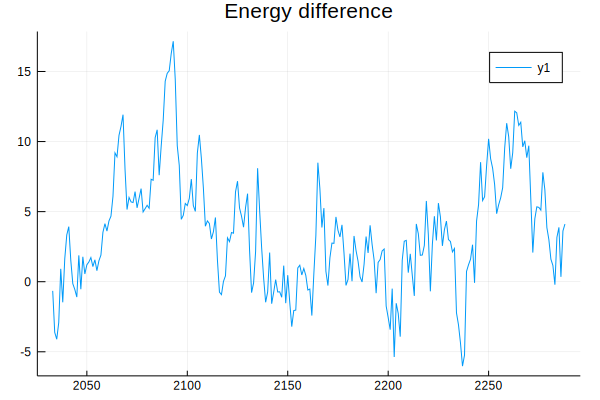

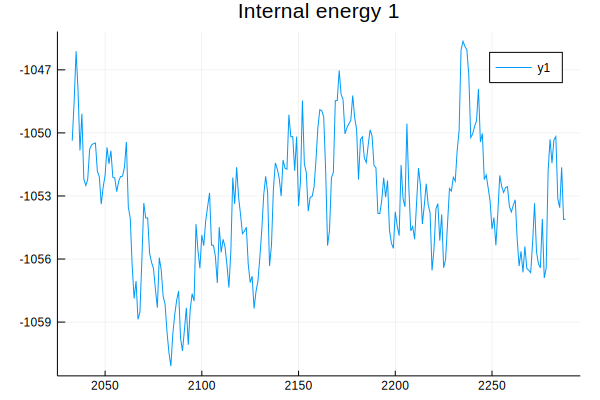

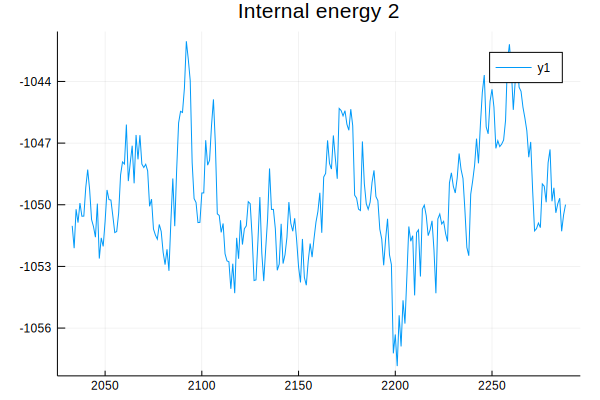

It is true that all arrays has equal size 2288


In [168]:
N = size(E₁,1)
println("It is $(size(E₁,1) == size(E₂,1) == size(dE, 1)) that all arrays has equal size $(N)")
int = 2033:N
plt = plot(int, dE[int], title="Energy difference")
display(plt)
plt = plot(int, E₁[int], title="Internal energy 1")
display(plt)
plt = plot(int, E₂[int], title="Internal energy 2")
display(plt)

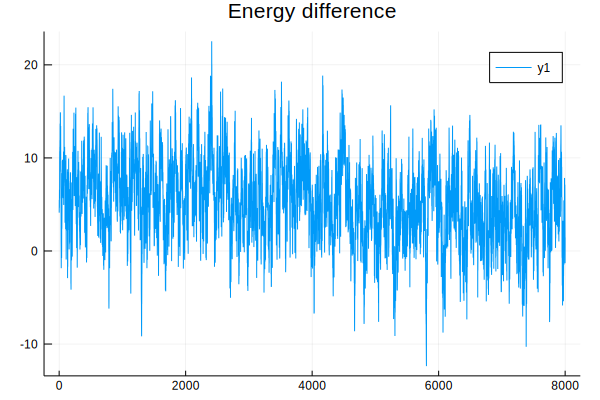

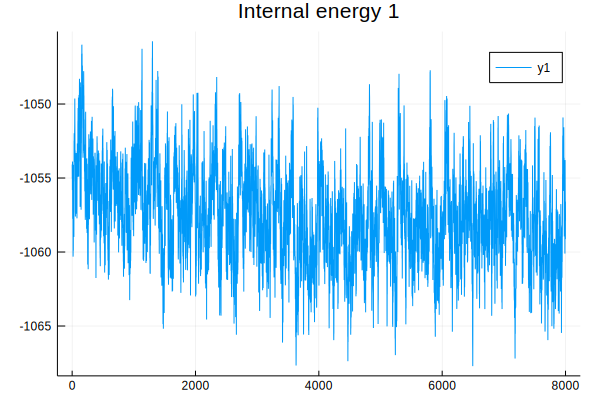

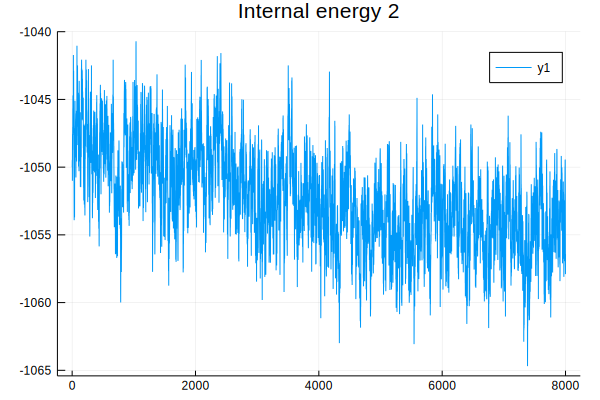

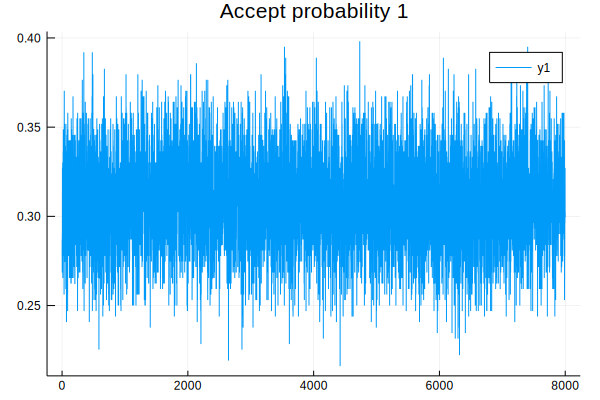

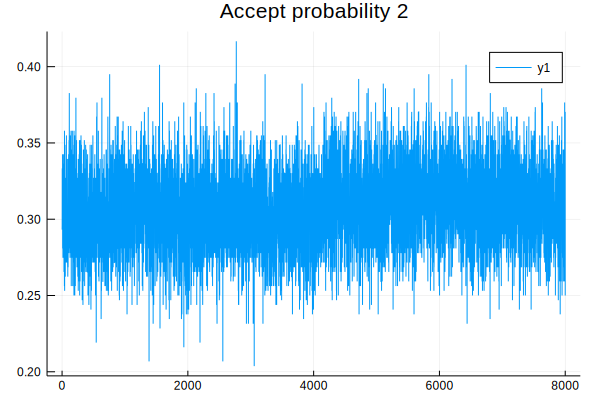

In [169]:
sim₁ = copy(sim)
sim₂ = copy(sim)
T = 4000
dE = zeros(2T)
E₁ = zeros(2T)
E₂ = zeros(2T)
p₁ = zeros(2T)
p₂ = zeros(2T)
for i = 1:T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end
adjustSimConstants!(sim₁, ψ₁)
adjustSimConstants!(sim₂, ψ₂)
for i = T+1:2T
    E₁[i] = E(ψ₁)
    E₂[i] = E(ψ₂)
    dE[i] = E₂[i]-E₁[i]
    p₁[i] = mcSweepFrac!(ψ₁, sim₁)
    p₂[i] = mcSweepFrac!(ψ₂, sim₂)
end

# Plotting results
plt = plot(1:2T, dE, title="Energy difference")
display(plt)
plt = plot(1:2T, E₁, title="Internal energy 1")
display(plt)
plt = plot(1:2T, E₂, title="Internal energy 2")
display(plt)
plt = plot(1:2T, p₁, title="Accept probability 1")
display(plt)
plt = plot(1:2T, p₂, title="Accept probability 2")
display(plt)

In [147]:
@show mean(dE)
@show std(dE)
@show std(dE)/sqrt(size(dE,1))

mean(dE) = 4.7329984047018
std(dE) = 6.153911041424112
std(dE) / sqrt(size(dE, 1)) = 0.06880281708055419


0.06880281708055419